## K-Store Ecommerce Sales Order Analysis
##### Main focus: Visualizing data and fitting multiple linear regression

#### 1. Import library and load data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

sns.set_theme()

pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.float_format', '{:,.3f}'.format)

In [2]:
def load_data(filename: str, **kwargs) -> pd.DataFrame:
    """Read data from a filename and output it as a dataframe"""
    df = pd.read_excel(filename, **kwargs)
    print(df.head())
    return df

df = load_data('~/Documents/GitHub/Data-Science/eCommerce-sales-analysis/dataset/Sales Order Dataset.xlsx', sheet_name='Data')

   brand platform order_status  quantity  selling_price  paid_price  seller_coupon  vendor_coupon  order_value payment_method
0    ARI      AMZ     canceled         1          3.554       0.248          0.000          3.306        3.554        ewallet
1    ARI      AMZ     canceled         2          7.025       0.000          7.025          7.025       27.851        ewallet
2    ARI      AMZ    completed         2         10.950       9.125          0.702          1.825       27.851        ewallet
3  SAMSK      WEB    completed         3          5.165       1.033          0.000          4.132        9.876        ewallet
4    ARI      AMZ    completed         3          1.860       0.000          1.860          1.860        9.876            cod


#### 2. Brief overview

In [3]:
def data_overview():
    print('1. Data description: ')
    print(df.describe(include='all'))  # Description of dataset
    print(f'2. Shape of dataset: {df.shape}')
    print('3. Columns datatype: ')
    for group, column in df.columns.to_series().groupby(df.dtypes):  # Datatype of each column
        print(group, end='\t| ')
        for name in column:
            print(name, end=', ')
        print()
    
data_overview()

1. Data description: 
        brand platform order_status  quantity  selling_price  paid_price  seller_coupon  vendor_coupon  order_value payment_method
count    2442     2442         2442 2,442.000      2,442.000   2,442.000      2,442.000      2,442.000    2,442.000           2340
unique      3        3            4       NaN            NaN         NaN            NaN            NaN          NaN              4
top     SAMSK      WEB    completed       NaN            NaN         NaN            NaN            NaN          NaN            cod
freq     1033     1473         1695       NaN            NaN         NaN            NaN            NaN          NaN           1807
mean      NaN      NaN          NaN     1.811          5.569       2.259          1.915          2.746       14.969            NaN
std       NaN      NaN          NaN     1.109          3.668       4.104          2.621          2.401       15.976            NaN
min       NaN      NaN          NaN     1.000          0.000 

#### 3. Data visualization
##### a. Selling price histogram

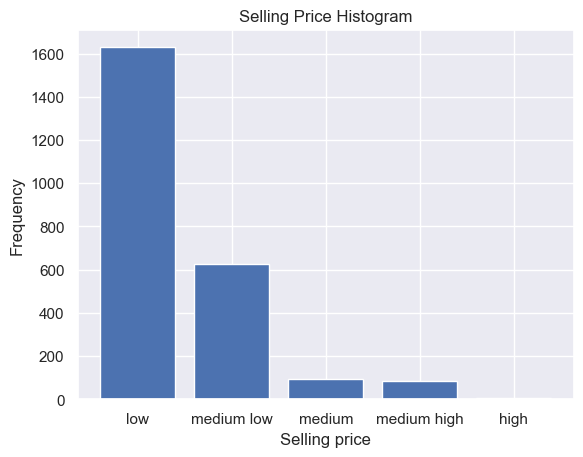

In [4]:
def plot_bins(data: pd.Series, no_bin: int, group_name: list) -> pd.Series:
    """Cut data into different bins and assign names for each bin"""
    bins = np.linspace(data.min(), data.max(), no_bin)
    data = pd.cut(data, bins, labels=group_name, include_lowest=True)
    plt.bar(group_name, data.value_counts())
    plt.title("Selling Price Histogram")
    plt.xlabel("Selling price")
    plt.ylabel("Frequency")
    plt.show()

group_name = ["low", "medium low", "medium", "medium high", "high"]
plot_bins(df['selling_price'], 6, group_name=group_name)

##### b. Sales quantity of each brand in 3 platforms

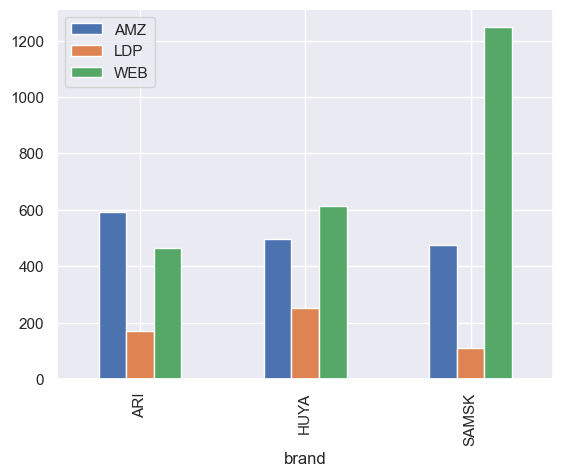

In [5]:
pd.pivot_table(data=df, index=['brand'], columns='platform', values=['quantity'],
               aggfunc='sum').plot(kind='bar', subplots=False, use_index=True)
plt.legend(["AMZ", "LDP", "WEB"])
plt.show()

##### c. Average amount of seller and vendor coupons used (by platform and brand)

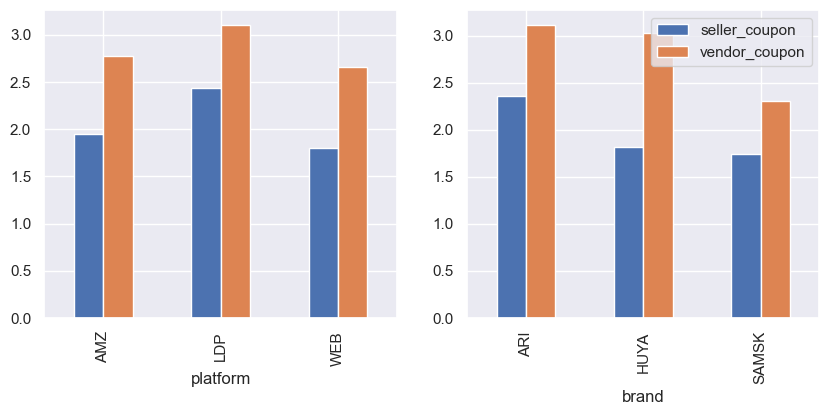

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
pd.pivot_table(data=df, index='platform', values=['seller_coupon', 'vendor_coupon'],
               aggfunc='mean').plot(kind='bar', subplots=False, use_index=True, ax=ax1, legend=None)
pd.pivot_table(data=df, index='brand', values=['seller_coupon', 'vendor_coupon'],
               aggfunc='mean').plot(kind='bar', subplots=False, use_index=True, ax=ax2)
plt.show()

##### d. Order status of each product

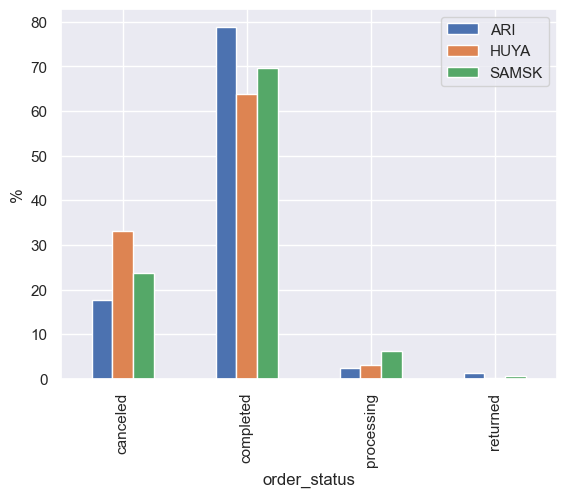

In [7]:
status_percent = pd.DataFrame()
table = pd.pivot_table(data=df, index='order_status', columns='brand', fill_value=0, values=['quantity'], aggfunc='sum')
status_percent['% ARI'] = round((table['quantity']['ARI'] / table['quantity']['ARI'].sum()*100), 2)
status_percent['% HUYA'] = round((table['quantity']['HUYA'] / table['quantity']['HUYA'].sum()*100), 2)
status_percent['% SAMSK'] = round((table['quantity']['SAMSK'] / table['quantity']['SAMSK'].sum()*100), 2)

status_percent.plot(kind='bar', subplots=False, use_index=True)
plt.legend(["ARI", "HUYA", "SAMSK"])
plt.ylabel('%')
plt.show()

##### e. Outliers in selling price, vendor coupon by order status

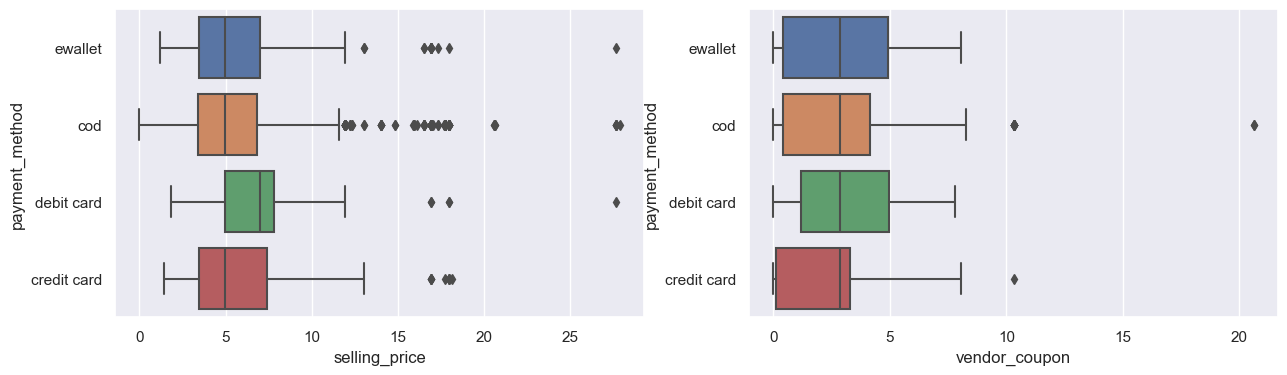

In [8]:
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(121)
sns.boxplot(x='selling_price', y='payment_method', data=df, ax=ax1)  # pass ax1
ax2 = fig.add_subplot(122)
sns.boxplot(x='vendor_coupon', y='payment_method', data=df, ax=ax2)  # pass ax2
plt.show()

#### 4. Data preprocessing
##### a. Checking missing values

In [9]:
def check_missing_data(data: pd.DataFrame) -> pd.Series:
    """Check for missing data in the df (display in descending order)"""
    result = ((data.isnull().sum() * 100)/ len(data)).sort_values(ascending=False)
    return result

check_missing_data(df)

payment_method   4.177
brand            0.000
platform         0.000
order_status     0.000
quantity         0.000
selling_price    0.000
paid_price       0.000
seller_coupon    0.000
vendor_coupon    0.000
order_value      0.000
dtype: float64

##### b. Transform data

In [10]:
# replace null value in payment method with the most frequent payment option
fre = df['payment_method'].value_counts().idxmax()
df["payment_method"].replace(np.nan, fre, inplace=True)
# Get dummy variables
payment_dummy = pd.get_dummies(df["payment_method"])
status_dummy = pd.get_dummies(df["order_status"])

##### c. Check correlation of dataset

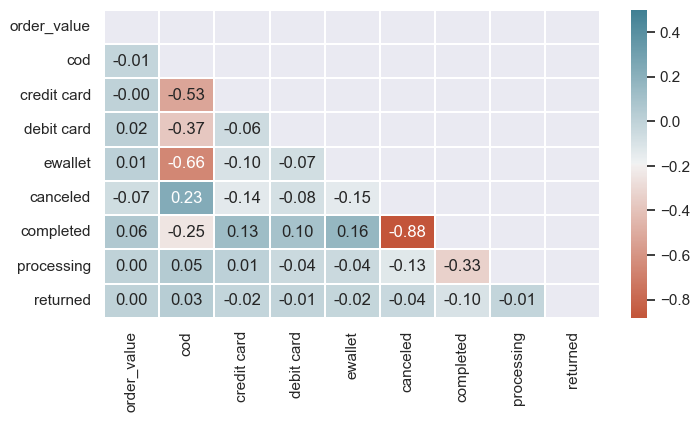

In [11]:
def corr_heatmap(data: pd.DataFrame):
    """Draw heatmap to show data correlation"""
    corr = data.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    palette = sns.diverging_palette(20, 220, n=256) # "YlGnBu"
    # Heatmap
    plt.figure(figsize=(8, 4))
    sns.heatmap(corr, vmax=.5, mask=mask, annot=True, fmt='.2f', linewidths=.2, 
                cmap=palette)  # .get_figure().savefig('chart.png')
    plt.show()
    
data = pd.concat([df[['order_value']], payment_dummy, status_dummy], axis=1)
corr_heatmap(data)

#### 6. Model development
##### a. Multiple linear regression model: 

In [12]:
X_features = ['quantity', 'selling_price', 'seller_coupon', 'vendor_coupon']
X = df[X_features]
Y = df['order_value']
lm1 = LinearRegression().fit(X, Y)
lm1_yhat = lm1.predict(X)
print('Coefficient is: ', lm1.coef_, ' intercept is: ', lm1.intercept_)

Coefficient is:  [ 3.02590953  1.1418022   3.01584768 -1.71593869]  intercept is:  2.066239749744499


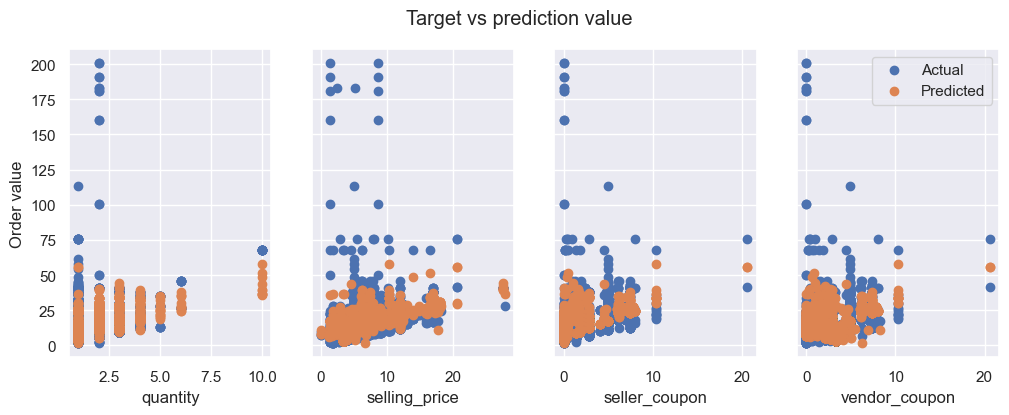

In [13]:
def data_residual_plot(df, x_features, yname):
    fig,ax=plt.subplots(1,len(x_features),figsize=(12,4),sharey=True)
    for i in range(len(ax)):
        sns.residplot(x=x_features[i], y=yname, data=df, ax=ax[i], label=False)
    fig.suptitle("Residuals plot")
    plt.show()
  

def distribution_plot(actual_data, predicted_data):
    plt.figure(figsize=(8, 4))
    ax1 = sns.kdeplot(actual_data, color="r", label="Actual", clip=(-5, 70))
    ax2 = sns.kdeplot(predicted_data, color="b", label="Predicted", ax=ax1, clip=(-5, 70))
    plt.title("Actual vs Predicted values for order value")
    plt.xlabel('Order value')
    plt.ylabel('Proportion of orders')
    plt.legend(); plt.show(); plt.close()
    

def data_scatter_plot(x, x_features, y_actual, y_predicted):
    fig,ax=plt.subplots(1,len(x_features),figsize=(12,4),sharey=True)
    for i in range(len(ax)):
        ax[i].scatter(x[x_features[i]], y_actual, label = 'Actual')
        ax[i].set_xlabel(x_features[i])
        ax[i].scatter(x[x_features[i]], y_predicted, label = 'Predicted')
    ax[0].set_ylabel("Order value"); ax[3].legend()
    fig.suptitle("Target vs prediction value")
    plt.show()


data_scatter_plot(X, X_features, Y, lm1_yhat)

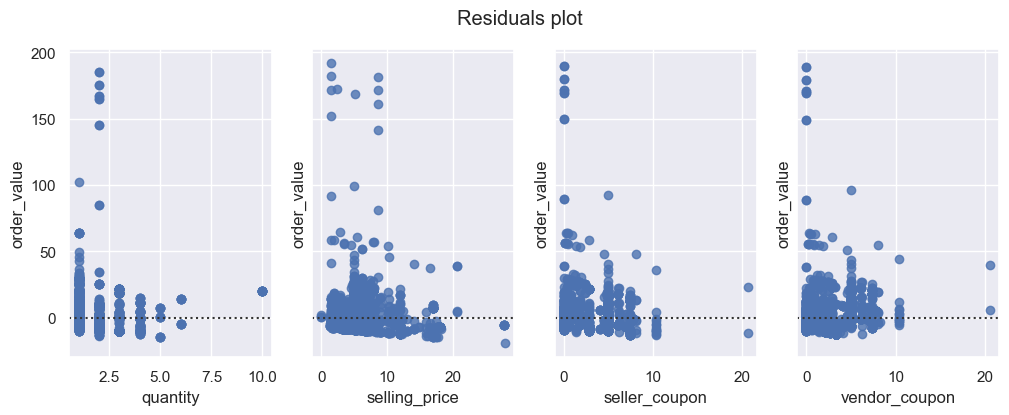

In [14]:
data_residual_plot(df, X_features, 'order_value')  

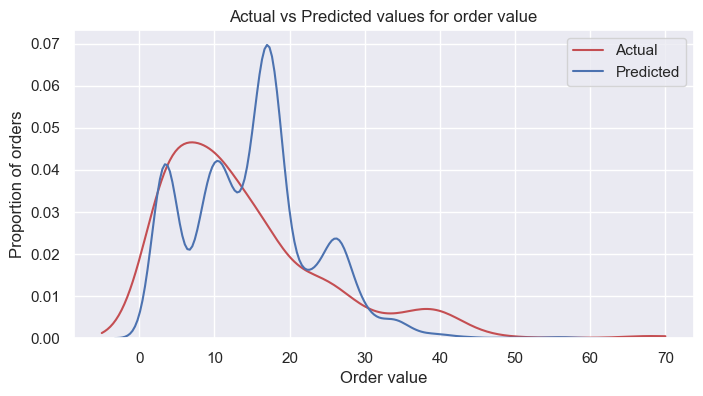

In [15]:
distribution_plot(Y, lm1_yhat)

In [16]:
print('Multiple Linear Regression parameters:')
print('\tThe R-square: {:.3f}'.format(lm1.score(X, Y)))
print('\tOutput of the 1st 4 predicted value:', lm1_yhat[0:4])
mse = mean_squared_error(Y, lm1_yhat)
print('\tMean square error of actual & predicted order value: {:.3f}'.format(mse))
print("")

Multiple Linear Regression parameters:
	The R-square: 0.263
	Output of the 1st 4 predicted value: [ 3.47726885 25.27057536 19.60655627  9.9510512 ]
	Mean square error of actual & predicted order value: 188.012



In [17]:
scores = cross_val_score(lm1, X, Y, cv=4)
print(f'Each element in the array has the average R^2 value in the fold {scores}')
print("The mean of the folds are {:.3f}, and standard deviation is {:.3f}".format(scores.mean(), scores.std()))

Each element in the array has the average R^2 value in the fold [ 0.42475261  0.66754928  0.07192843 -0.09227972]
The mean of the folds are 0.268, and standard deviation is 0.297


##### b. Polynomial multiple linear regression model

In [18]:
# Pipeline: simplify the steps of processing the data
Input = [('scale',StandardScaler()), ('polynomial', PolynomialFeatures(degree=2, include_bias=False)), ('model',LinearRegression())]
pipe = Pipeline(Input)
pipe.fit(X, Y)
ypipe = pipe.predict(X)
# ypipe[0:4]
r_squared = r2_score(Y, ypipe)
print(f'The R-square value is: {r_squared}')
mean_squared_error(Y, ypipe)

The R-square value is: 0.29315925939903564


180.3388603252859

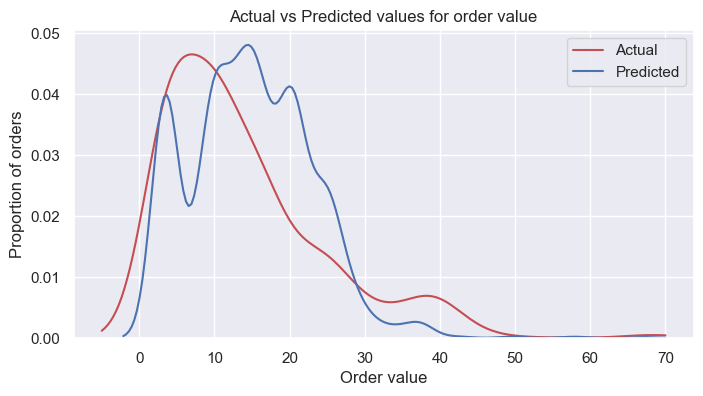

In [19]:
distribution_plot(Y, ypipe)

In [20]:
scores = cross_val_score(pipe, X, Y, cv=4)
print(f'Each element in the array has the average R^2 value in the fold {scores}')
print("The mean of the folds are {:.3f}, and standard deviation is {:.3f}".format(scores.mean(), scores.std()))

Each element in the array has the average R^2 value in the fold [ 0.47504666  0.74734816  0.06405251 -0.15960461]
The mean of the folds are 0.282, and standard deviation is 0.352
